C:\Users\esteb\AppData\Local\Temp\ipykernel_13936\4085912362.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area    = gdf_cont.unary_union.area
C:\Users\esteb\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\esteb\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\esteb\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\esteb\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
C:\Users\esteb\anacon

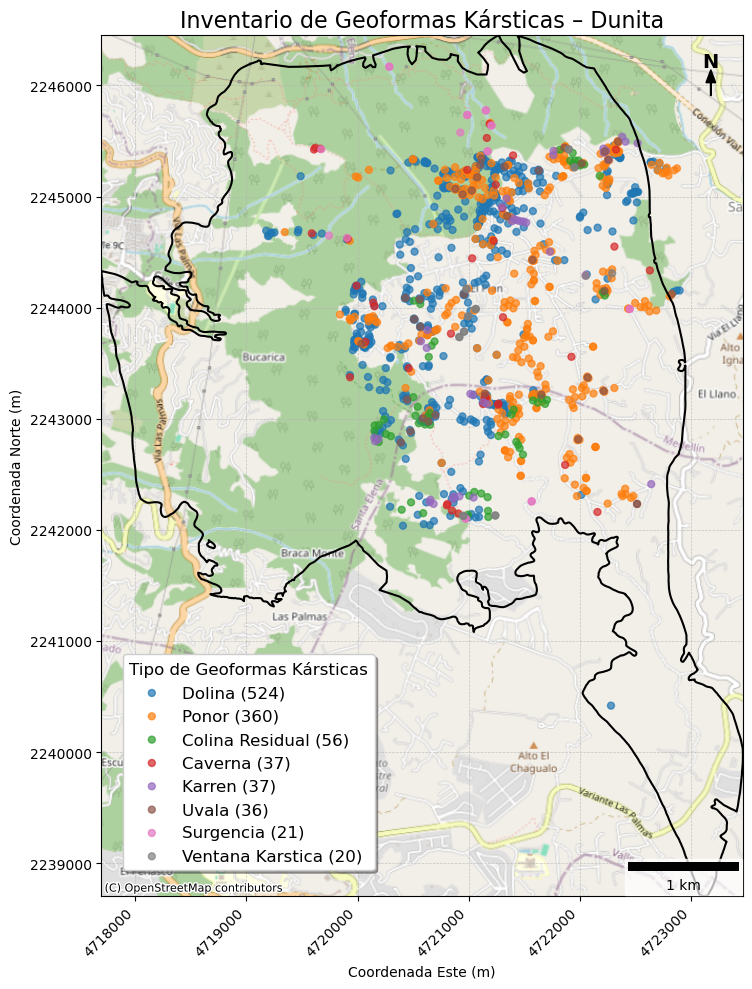

In [17]:
# Análisis de patrones de puntos geoformas kársticas Dunita

# Visualización

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter
import numpy as np
import math
from scipy.spatial import KDTree, distance_matrix

# RUTAS DE ARCHIVOS
shp_puntos   = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
shp_contorno = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
out_png      = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG"

# LECTURA Y PREPARACIÓN DE DATOS
gdf_pts  = gpd.read_file(shp_puntos).to_crs(epsg=9377)
gdf_pts  = gdf_pts[gdf_pts.geometry.is_valid].drop_duplicates(subset="geometry").reset_index(drop=True)
gdf_cont = gpd.read_file(shp_contorno).to_crs(epsg=9377)

coords  = np.vstack((gdf_pts.geometry.x, gdf_pts.geometry.y)).T
tree    = KDTree(coords)
n_pts   = len(coords)
area    = gdf_cont.unary_union.area
density = n_pts / area

# MAPA GLOBAL
conteo_tipos = gdf_pts['Tipo'].value_counts().to_dict()
fig, ax = plt.subplots(figsize=(10,10))
gdf_cont.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, zorder=3)
for tipo, cnt in conteo_tipos.items():
    gdf_pts[gdf_pts['Tipo']==tipo].plot(
        ax=ax, marker='o', linestyle='', markersize=25, alpha=0.7,
        label=f"{tipo} ({cnt})", zorder=2
    )
minx, miny, maxx, maxy = gdf_cont.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
cx.add_basemap(ax, crs=gdf_cont.crs.to_string(),
               source=cx.providers.OpenStreetMap.Mapnik, zoom='auto')
ax.add_artist(ScaleBar(1, "m", location="lower right", frameon=True, box_alpha=0.7))
xn, yn = 0.95, 0.97
ax.text(xn, yn, "N", transform=ax.transAxes,
        ha="center", va="center", fontsize=14, fontweight="bold", zorder=5)
ax.arrow(xn, yn-0.04, 0, 0.03, transform=ax.transAxes,
         head_width=0.015, head_length=0.015, fc='black', ec='black',
         length_includes_head=True, zorder=5)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f"{int(x)}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: f"{int(y)}"))
plt.xticks(rotation=45, ha='right')
ax.set_xlabel("Coordenada Este (m)")
ax.set_ylabel("Coordenada Norte (m)")
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(title="Tipo de Geoformas Kársticas",
          loc='lower left', bbox_to_anchor=(0.02,0.02),
          frameon=True, fontsize=12, title_fontsize=12,
          fancybox=True, shadow=True)
ax.set_title("Inventario de Geoformas Kársticas – Dunita", fontsize=16)
plt.tight_layout()
fig.savefig(f"{out_png}/01_distribucion_global.png", dpi=300, bbox_inches='tight')
plt.show()



Índice R = 0.385 (obs=27.6 m | CSR=71.5 m)


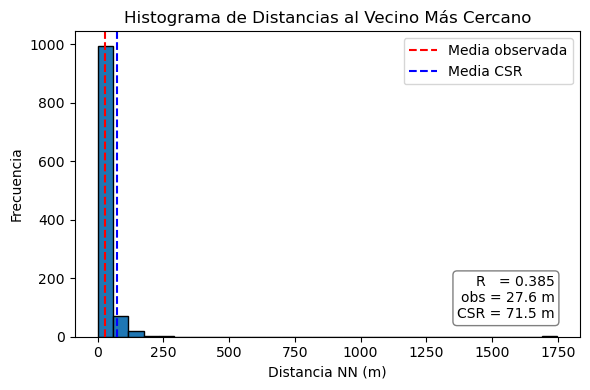

In [4]:
# Vecinos más cercanos e histograma

distances, _ = tree.query(coords, k=2)
d_nn = distances[:,1]
d_nn = d_nn[np.isfinite(d_nn)]
mean_obs = d_nn.mean()
mean_exp = 0.5 / math.sqrt(density)
R = mean_obs / mean_exp

print(f"Índice R = {R:.3f} (obs={mean_obs:.1f} m | CSR={mean_exp:.1f} m)")

ig, ax = plt.subplots(figsize=(6,4))

ax.hist(d_nn, bins=30, edgecolor="black")
ax.axvline(mean_obs, color="red",   linestyle="--", label="Media observada")
ax.axvline(mean_exp, color="blue",  linestyle="--", label="Media CSR")

ax.set_xlabel("Distancia NN (m)")
ax.set_ylabel("Frecuencia")
ax.set_title("Histograma de Distancias al Vecino Más Cercano")
ax.legend()

texto = (
    f"R   = {R:.3f}\n"
    f"obs = {mean_obs:.1f} m\n"
    f"CSR = {mean_exp:.1f} m"
)
# Coordenadas relativas al eje: (0.95, 0.05) → esquina inferior derecha
ax.text(0.95, 0.05, texto,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))

plt.tight_layout()
fig.savefig(f"{out_png}/02_histograma_nn.png", dpi=300)
plt.show()



C:\Users\esteb\anaconda3\Lib\site-packages\scipy\spatial\_kdtree.py:60: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(y-x)**p, axis=-1)


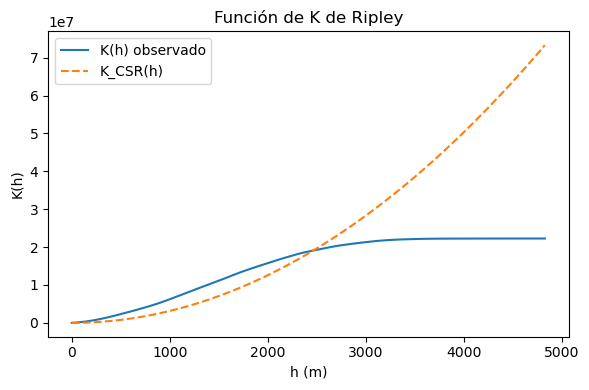

In [5]:
# K de Ripley

minx, miny, maxx, maxy = gdf_cont.total_bounds
max_dist = np.hypot(maxx-minx, maxy-miny)/2
r_vals = np.linspace(0, max_dist, 100)
dmat = distance_matrix(coords, coords)
np.fill_diagonal(dmat, np.inf)
counts = [(dmat <= r).sum() for r in r_vals]
Kest = (area / (n_pts*(n_pts-1))) * np.array(counts)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(r_vals, Kest, label="K(h) observado")
ax.plot(r_vals, math.pi*r_vals**2, linestyle="--", label="K_CSR(h)")
ax.set_xlabel("h (m)")
ax.set_ylabel("K(h)")
ax.set_title("Función de K de Ripley")
ax.legend()
plt.tight_layout()
fig.savefig(f"{out_png}/03_ripley_K.png", dpi=300)
plt.show()

C:\Users\esteb\AppData\Local\Temp\ipykernel_13936\3137639816.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mascara = geoformas_gdf.within(contorno_gdf.unary_union)


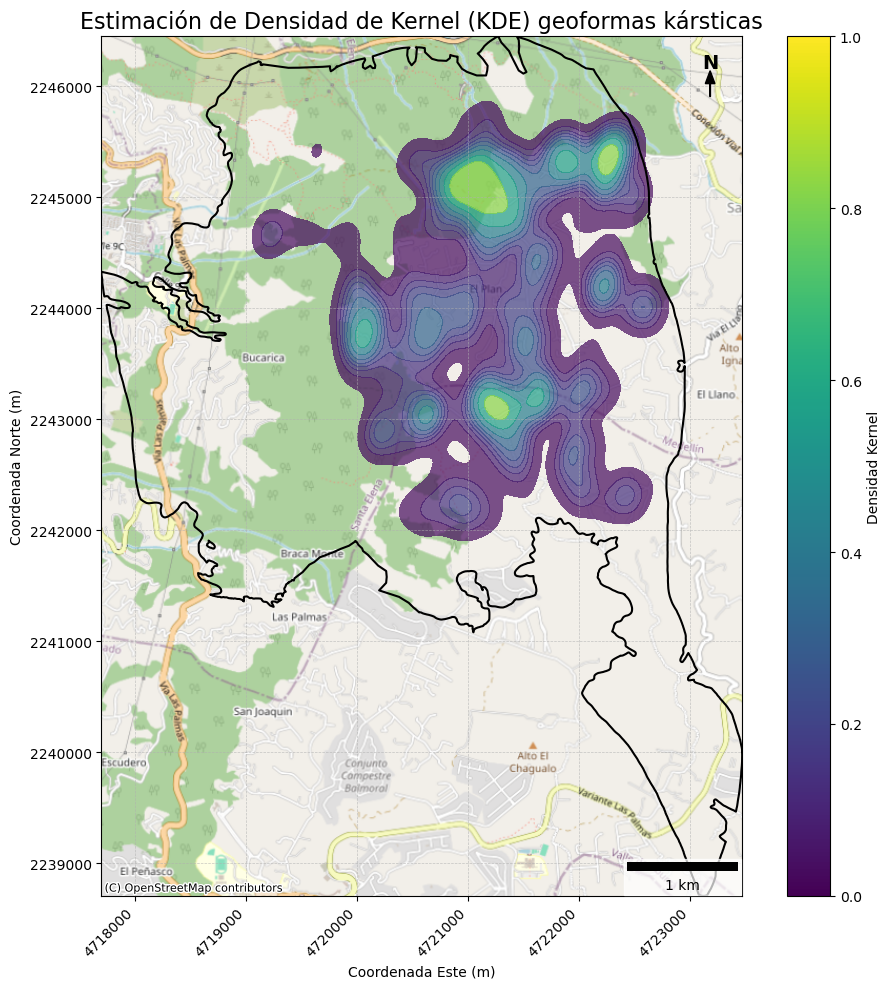

KDE global guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\KDE_global.png
Interpretación: colores más intensos → mayor concentración.


In [8]:
# Densidad de Kernel (KDE)

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter

# Ejes como enteros
def integer_formatter(x, pos):
    return f"{int(x)}"

# Rutas de los datos y salida 
ruta_contorno      = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_geoformas     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp" 
output_png_kde     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\KDE_global.png"

# Carga de las capas vectoriales
contorno_gdf   = gpd.read_file(ruta_contorno)
geoformas_gdf  = gpd.read_file(ruta_geoformas)
 
if contorno_gdf.crs != geoformas_gdf.crs:
    geoformas_gdf = geoformas_gdf.to_crs(contorno_gdf.crs)

mascara = geoformas_gdf.within(contorno_gdf.unary_union)
geoformas_en_area_gdf = geoformas_gdf[mascara].copy()

# Comprobación mínima de puntos para KDE 
if len(geoformas_en_area_gdf) > 5:
    # --- Creación de figura y ejes ---
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Contorno de la Dunita 
    contorno_gdf.boundary.plot(
        ax=ax, edgecolor='black', linewidth=1.5, zorder=2
    )
    
    # Estimación KDE con seaborn
    sns.kdeplot(
        x=geoformas_en_area_gdf.geometry.x,
        y=geoformas_en_area_gdf.geometry.y,
        ax=ax,
        fill=True,
        cmap="viridis",
        levels=10,
        thresh=0.05,
        alpha=0.7,
        bw_adjust=0.5,
        zorder=1
    )
    
    # Añadir colorbar con gradiente continuo
    sm = plt.cm.ScalarMappable(cmap="viridis")
    sm.set_array([])
    cbar = fig.colorbar(
        sm, ax=ax,
        label="Densidad Kernel",
        fraction=0.046, pad=0.04
    )
    
    # Títulos y etiquetas
    ax.set_title("Estimación de Densidad de Kernel (KDE) geoformas kársticas", fontsize=16)
    ax.set_xlabel("Coordenada Este (m)")
    ax.set_ylabel("Coordenada Norte (m)")
    
    # Ejes y rotar etiquetas X
    ax.xaxis.set_major_formatter(FuncFormatter(integer_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(integer_formatter))
    plt.xticks(rotation=45, ha='right')
    
    # Añadir barra de escala
    ax.add_artist(
        ScaleBar(dx=1, units="m", location="lower right",
                 frameon=True, color='black', box_alpha=0.7)
    )
    
    # Flecha de Norte
    x_n, y_n = 0.95, 0.97
    ax.text(
        x_n, y_n, "N", transform=ax.transAxes,
        ha="center", va="center",
        fontsize=14, fontweight="bold", zorder=5
    )
    ax.arrow(
        x_n, y_n - 0.04, 0, 0.03,
        transform=ax.transAxes,
        head_width=0.015, head_length=0.015,
        fc='black', ec='black',
        length_includes_head=True, zorder=5
    )
    
    # Basemap
    cx.add_basemap(
        ax, crs=contorno_gdf.crs.to_string(),
        source=cx.providers.OpenStreetMap.Mapnik,
        zoom='auto'
    )
    
    # Ajustar límites y proporción
    minx, miny, maxx, maxy = contorno_gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_aspect('equal', 'box')
    
    # Grilla punteada
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Layout, exportación y visualización
    plt.tight_layout()
    fig.savefig(output_png_kde, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"KDE global guardado en: {output_png_kde}")
    print("Interpretación: colores más intensos → mayor concentración.")
else:
    print(f"No hay suficientes puntos (>5) en 'geoformas_en_area_gdf' para KDE Global. "
          f"Solo {len(geoformas_en_area_gdf)} puntos encontrados.")



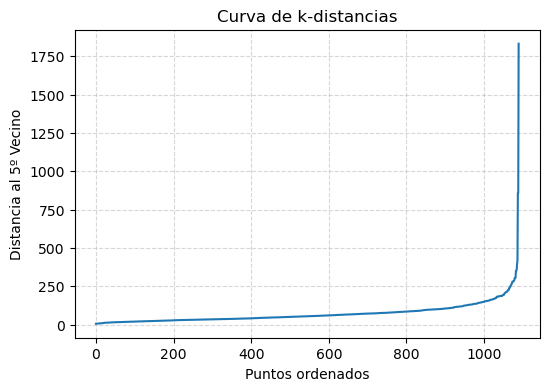

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Extraer coordenadas de gdf_pts 
xs = gdf_pts.geometry.x.values
ys = gdf_pts.geometry.y.values
coords = np.column_stack((xs, ys))  

# Gráfico de k-distancias al 5º vecino
min_samples0 = 5
nbrs = NearestNeighbors(n_neighbors=min_samples0).fit(coords)
distances, _ = nbrs.kneighbors(coords)
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_dist, linewidth=1.5)
plt.ylabel(f"Distancia al {min_samples0}º Vecino")
plt.xlabel("Puntos ordenados")
plt.title("Curva de k-distancias")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

C:\Users\esteb\anaconda3\Lib\site-packages\matplotlib\axes\_base.py:2923: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


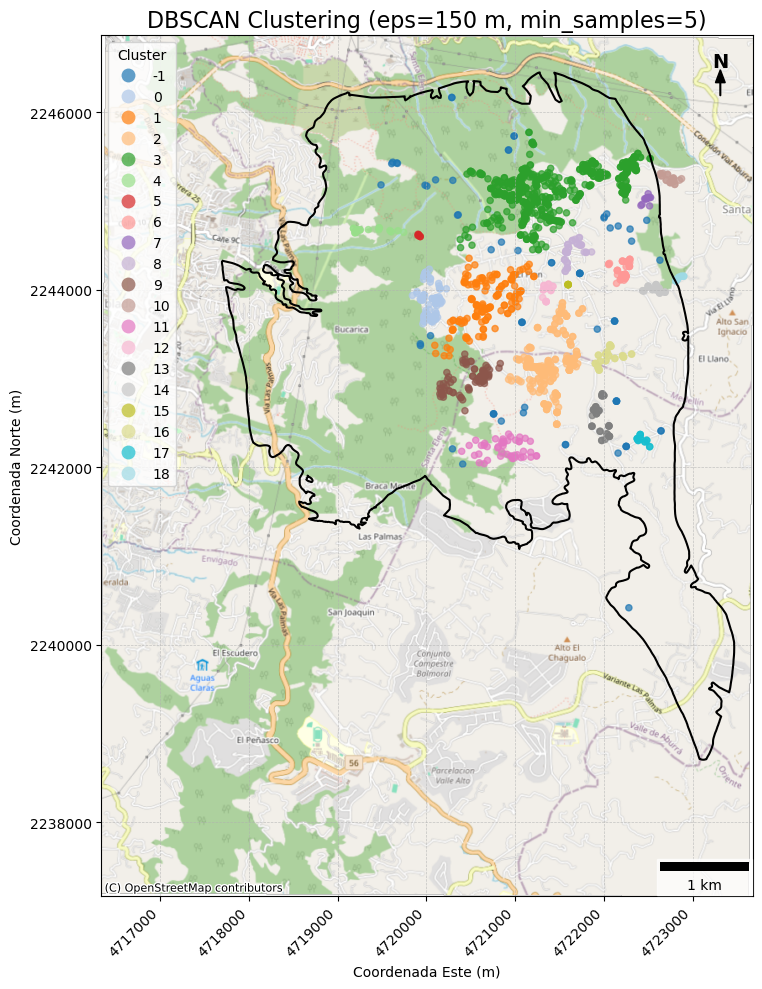

DBSCAN global guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\07_dbscan_global.png


In [16]:
#  DBSCAN: Clustering 

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import DBSCAN

# Carga de datos 
ruta_contorno    = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_puntos      = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
output_png_dbscan = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\07_dbscan_global.png"

# Formateador de ejes como enteros 
def integer_formatter(x, pos):
    return f"{int(x)}"

contorno_gdf            = gpd.read_file(ruta_contorno).to_crs(epsg=9377)
geoformas_en_area_gdf   = gpd.read_file(ruta_puntos).to_crs(epsg=9377)
coords                  = np.vstack((geoformas_en_area_gdf.geometry.x,
                                     geoformas_en_area_gdf.geometry.y)).T

# Parámetros DBSCAN 
eps         = 150    # metros
min_samples = 5      # puntos mínimos

# Ajustar modelo y asignar etiquetas
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
labels = db.fit_predict(coords)
geoformas_en_area_gdf['cluster'] = labels

# Límites del área de estudio
minx, miny, maxx, maxy = contorno_gdf.total_bounds

# Crear figura
fig, ax = plt.subplots(figsize=(10,10))

# Contorno
contorno_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, zorder=2)

# Puntos coloreados por cluster
geoformas_en_area_gdf.plot(
    ax=ax,
    column='cluster',
    categorical=True,
    cmap='tab20',
    legend=True,
    markersize=20,
    alpha=0.7,
    legend_kwds={'title': 'Cluster'}
)

# Barra de escala y flecha Norte
ax.add_artist(ScaleBar(dx=1, units="m", location="lower right",
                      frameon=True, color='black', box_alpha=0.7))
x_n, y_n = 0.95, 0.97
ax.text(x_n, y_n, "N", transform=ax.transAxes,
        ha="center", va="center", fontsize=14, fontweight="bold", zorder=5)
ax.arrow(x_n, y_n-0.04, 0, 0.03, transform=ax.transAxes,
         head_width=0.015, head_length=0.015,
         fc='black', ec='black', length_includes_head=True, zorder=5)

# Basemap 
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
cx.add_basemap(
    ax, crs=contorno_gdf.crs.to_string(),
    source=cx.providers.OpenStreetMap.Mapnik,
    zoom='auto',
    reset_extent=False
)

# Formato de ejes y grilla
ax.xaxis.set_major_formatter(FuncFormatter(integer_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(integer_formatter))
plt.xticks(rotation=45, ha='right')
ax.set_xlabel("Coordenada Este (m)")
ax.set_ylabel("Coordenada Norte (m)")
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Título 
ax.set_title(f"DBSCAN Clustering (eps={eps} m, min_samples={min_samples})", fontsize=16)
plt.tight_layout()

fig.savefig(output_png_dbscan, dpi=300, bbox_inches='tight')
plt.show()

print(f"DBSCAN global guardado en: {output_png_dbscan}")
